# Test neural network

In this notebook we use the same set of features (and processing steps) as used for the baseline LGBM model but instead fit a simple feedforward neural network in Keras.

## Set-up

In [119]:
import os
import pickle

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout
import tensorflow as tf
from keras import initializers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('..')

In [3]:
# Need to import class for creating baseline model (see explanation in 02-Baseline model)
from src.models.baseline_model import BaselineModel

In [4]:
pd.options.display.max_columns = None

## Load data

In [5]:
train = pd.read_parquet('data/interim/train.parquet')
print(f"Train size: {train.shape}")
dev = pd.read_parquet('data/interim/dev.parquet')
print(f"Dev size: {dev.shape}")

Train size: (184506, 122)
Dev size: (61502, 122)


In [6]:
X_train = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y_train = train['TARGET']
X_dev = dev.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y_dev = dev['TARGET']

## Get baseline preprocessing pipeline

In [7]:
end_to_end_pipeline = pickle.load(open('models/baseline_model_pipeline.pickle', 'rb'))

In [8]:
end_to_end_pipeline

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('drop_columns',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<bound method BaselineModel.drop_columns of <src.models.baseline_model.BaselineModel object at 0x1296e3150>>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args={'columns_to_drop': ['OWN_CAR_AGE',
                                                                                   'OCCUPATION_TYPE',...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learn

In [9]:
end_to_end_pipeline.named_steps.keys()

dict_keys(['preprocessing', 'processing', 'model'])

We take the same processing pipeline as used in the baseline model:

In [10]:
processing_pipeline = Pipeline(
    [
        ('preprocessing', end_to_end_pipeline.named_steps['preprocessing']),
        ('processing', end_to_end_pipeline.named_steps['processing'])
    ]
)

In [32]:
X_train_processed = processing_pipeline.fit_transform(X_train)

In [33]:
X_train_processed.shape

(184506, 166)

In [34]:
X_dev_processed = processing_pipeline.transform(X_dev)
X_dev_processed.shape

(61502, 166)

## Create neural network

In [120]:
def create_model(number_of_inputs):
    # Create network:
    model = Sequential()
    model.add(Dropout(0.15))
    model.add(Dense(30, input_dim=number_of_inputs, kernel_initializer=initializers.glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.15))
    model.add(Dense(30, input_dim=number_of_inputs, kernel_initializer=initializers.glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.15))
    model.add(Dense(30, input_dim=number_of_inputs, kernel_initializer=initializers.glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(
        Dense(1, input_dim=number_of_inputs, activation='sigmoid')
    )
    
    # Compile model:
    rocauc = tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')
    
    # Use Keras optimizer instead so that it can be saved with model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[rocauc])
    
    return model

In [121]:
number_of_inputs = X_train_processed.shape[1]

In [122]:
nn_model = create_model(number_of_inputs)
nn_model

## Fit neural network

In [145]:
nn_model.fit(X_train_processed, y_train.values, epochs=150, batch_size=256, validation_data=(X_dev_processed, y_dev.values))

Train on 184506 samples, validate on 61502 samples
Epoch 1/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2548 - auc_10: 0.7187 - val_loss: 0.2642 - val_auc_10: 0.7187
Epoch 2/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2547 - auc_10: 0.7187 - val_loss: 0.2615 - val_auc_10: 0.7187
Epoch 3/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2546 - auc_10: 0.7187 - val_loss: 0.2600 - val_auc_10: 0.7187
Epoch 4/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2547 - auc_10: 0.7187 - val_loss: 0.2650 - val_auc_10: 0.7187
Epoch 5/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2544 - auc_10: 0.7187 - val_loss: 0.2597 - val_auc_10: 0.7188
Epoch 6/150
184506/184506 [==============================] - 2s 9us/step - loss: 0.2545 - auc_10: 0.7188 - val_loss: 0.2606 - val_auc_10: 0.7188
Epoch 7/150
184506/184506 [==============================] - 2s 9us/step - loss

## Evaluate

In [159]:
roc_auc_score(y_train, nn_model.predict_proba(X_train_processed))

0.7621732666662693

In [160]:
roc_auc_score(y_dev, nn_model.predict_proba(X_dev_processed))

0.7152039179033474

__Why is there a difference between callback AUC and sklearn AUC?__

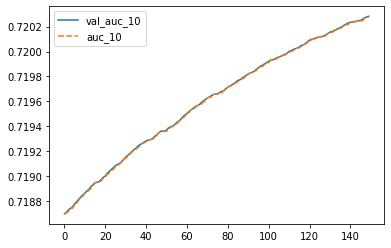

In [148]:
sns.lineplot(data=pd.DataFrame(nn_model.history.history)[['val_auc_10', 'auc_10']])

## Submit predictions

In [149]:
test = pd.read_parquet('data/interim/test_for_submission.parquet')
print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,None,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,None,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,None,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary spec

In [151]:
test_processed = processing_pipeline.transform(test.drop('SK_ID_CURR', axis=1))

In [152]:
test_predictions = nn_model.predict_proba(test_processed)

In [153]:
test_predictions

array([[0.07282105],
       [0.21680069],
       [0.05361745],
       ...,
       [0.06457591],
       [0.07756636],
       [0.10226679]], dtype=float32)

In [154]:
test['TARGET'] = test_predictions

In [156]:
test[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/neural_network_test_submission.csv', index=False)

In [157]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/neural_network_test_submission.csv -m "Test Neural Network"

100%|████████████████████████████████████████| 873k/873k [00:25<00:00, 35.3kB/s]
Successfully submitted to Home Credit Default Risk

## Summary

Private score: 0.70753

Public score: 0.70772

Worse than LightGBM! Looks like fitting a good NN is going to take more fine tuning!

## Save model

In [158]:
nn_model.save('models/test_neural_network.h5')

/Users/stevengeorge/opt/anaconda3/envs/kaggle-home-credit/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
